In [1]:
%matplotlib inline
from IPython.display import display

import matplotlib.pyplot as plt
import numpy
import pandas
import pickle
import os
import re

from sklearn import metrics

In [10]:
import colors

In [90]:
import seaborn
seaborn.set_style('whitegrid')
seaborn.set_palette('colorblind')

In [3]:
METRICS_COLS = ['AUC', 'RMSE', 'Accuracy', 'R2']

In [4]:
def get_runs(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'prediction' in run_prediction]

def get_learning(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'performance' in run_prediction]

In [5]:
def read_predictions(filename):
    with open(filename, 'rb') as prediction_file:
        return pickle.load(prediction_file)

def get_metrics_list(true, predicted):
    try:
        auc = metrics.roc_auc_score(true, predicted)
    except ValueError:
        auc = numpy.nan
    rmse = metrics.mean_squared_error(true, predicted)**0.5
    accuracy = metrics.accuracy_score(true, numpy.where(predicted > 0.5, 1, 0))
    r2 = metrics.r2_score(true, predicted)
    support = true.shape[0]
    return [auc, rmse, accuracy, r2, support]

def read_file_metrics(predictions_df):
    """Returns a DataFrame with values AUC, RMSE, APS, Accuracy, R2 Score"""
    metrics_list = []
    grouped = predictions_df.groupby(['run', 'period'])
    for (run, period), df in grouped:
        true, predicted = df.true.values, df.predicted.values
        metrics_list.append(get_metrics_list(true, predicted) + [run, period])
    return pandas.DataFrame(metrics_list, columns=METRICS_COLS + ['Support', 'Run', 'Period'])

In [6]:
def read_metrics(dirnames):
    metrics_dfs = []
    for dirname in dirnames:
        all_predictions = []
        for filename in get_runs(dirname):
            predictions_df = read_predictions(os.path.join(dirname, filename))
            try:
                file_metrics = read_file_metrics(predictions_df)
                file_metrics['Experiment'] = dirname[-16:]
                course = re.search('.*_c(\d+).*', filename)
                if course is not None:
                    file_metrics['Course'] = int(re.search('.*_c(\d+).*', filename).group(1))
                else:
                    file_metrics['Course'] = 1
                metrics_dfs.append(file_metrics)
                all_predictions.append(predictions_df)
            except ValueError:
                continue
        general_metrics = read_file_metrics(pandas.concat(all_predictions))
        general_metrics['Experiment'] = dirname[-16:]
        general_metrics['Course'] = -1
        metrics_dfs.append(general_metrics)
    return pandas.concat(metrics_dfs, ignore_index=True)

In [7]:
def read_performances(dirnames):
    results = {}
    for dirname in reversed(dirnames):
        dataframes = []
        for filename in get_learning(dirname):
            with open(os.path.join(dirname, filename), 'rb') as performance_file:
                performance_df = pickle.load(performance_file)
            course = re.search('.*_c(\d+).*', filename)
            if course is not None:
                performance_df['Course'] = int(course.group(1))
            else:
                performance_df['Course'] = 1
            performance_df['rmse'] = performance_df['mse']**0.5
            dataframes.append(performance_df)
        if len(dataframes) > 0:
            results[dirname] = pandas.concat(dataframes)
    return results

def graphic_performances(train_performances):
    performances = []
    for dirname, performance_dataframe in train_performances.items():
        perf = performance_dataframe.groupby(['epoch', 'run', 'Course']).agg({'rmse': 'std'}).groupby(
            'Course').agg('mean')
        perf['Experiment'] = dirname[-16:]
        performances.append(perf.reset_index())
    performances = pandas.concat(performances, ignore_index=True)
    seaborn.factorplot(x='Course', y='rmse', col="Experiment", data=performances, col_wrap=4)

def graphic_learning_curves(train_performances):
    for dirname, performance_dataframe in train_performances.items():
        print(dirname)
        performance_dataframe['epoch'] = performance_dataframe.epoch.astype(numpy.int)
        grid = seaborn.FacetGrid(data=performance_dataframe.loc[performance_dataframe['run'] == 0],
                                 col='Course', despine=True, ylim=[0, 0.5], aspect=1,
                                 palette='colorblind')
        mapped = grid.map(seaborn.pointplot, 'epoch', 'rmse', 'dataset').add_legend().set_xticklabels([])
        plt.show()

## Class distribution over periods

In [8]:
predictions_dfs = []
dirname = '/home/mteruel/edm/results/kdd_early_dropout/lstm/predictions/18-01-17-09-41/'
for filename in get_runs(dirname):
    predictions = read_predictions(os.path.join(dirname, filename))
    predictions = predictions[predictions.run == 0][['true', 'period']]
    grouped = predictions.groupby('period').agg({'true': ['sum', 'count']}).reset_index()
    grouped.loc[:,'noDropout'] = grouped['true']['count'] - grouped['true']['sum']
    grouped.loc[:,'Dropout'] = grouped['true']['sum']
    grouped.loc[:,'Ratio'] = grouped['true']['sum'] / (grouped['true']['count'])
    grouped = grouped.drop('true', axis=1)
    grouped = pandas.melt(grouped, id_vars=['period'], var_name='Label', value_vars=['noDropout', 'Dropout', 'Ratio'])
    grouped.loc[:,'Course'] = int(filename.split('_c')[1][:-2])
    predictions_dfs.append(grouped)
predictions_dfs = pandas.concat(predictions_dfs)

/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/ipykernel/__main__.py:10: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.


In [9]:
predictions_dfs[predictions_dfs.Label == 'Ratio'].groupby(['period']).agg(['max', 'min', 'mean', 'std'])

value                               Course                    
             max       min      mean       std    max min mean        std
period                                                                   
0       0.768786  0.488544  0.677670  0.093871     31   1   16  10.801234
1       0.892116  0.571285  0.752856  0.102109     31   1   16  10.801234
2       0.896907  0.657523  0.812497  0.081980     31   1   16  10.801234
3       0.899441  0.679969  0.814920  0.075379     31   1   16  10.801234

/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


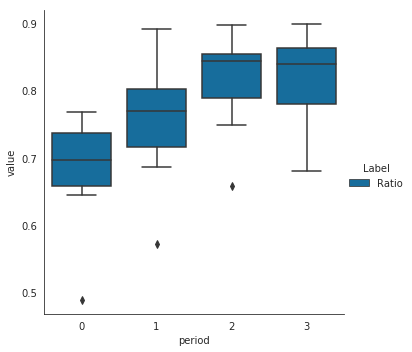

In [11]:
seaborn.factorplot(x='period', y='value', hue='Label', data=predictions_dfs[predictions_dfs.Label == 'Ratio'],
                   kind='box')

## Experiments with LSTM

In [12]:
LSTM_EXPERIMENTS_DIRS = [
    '/home/mteruel/edm/results/kdd_early_dropout/lstm/predictions/18-01-17-09-41/',
    '/home/mteruel/edm/results/kdd_early_dropout/lstm/predictions/18-01-17-20-53/',
    '/home/mteruel/edm/results/kdd_early_dropout/lstm/predictions/18-01-18-13-59/',
    '/home/mteruel/edm/results/kdd_early_dropout/lstm/predictions/18-01-18-17-46/',
    '/home/mteruel/edm/results/kdd_early_dropout/lstm/predictions/18-01-24-09-25/', # Full eval
    '/home/mteruel/edm/results/kdd_early_dropout/lstm/predictions/18-01-26-21-17/', # Full eval
]

In [13]:
lstm_metrics = read_metrics(LSTM_EXPERIMENTS_DIRS)

In [14]:
lstm_metrics

,AUC,RMSE,Accuracy,R2,Support,Run,Period,Experiment,Course
0,0.766332,0.445958,0.722838,0.204069,1353,0,0,/18-01-17-09-41/,1
1,0.822783,0.411183,0.765060,0.309681,1992,0,1,/18-01-17-09-41/,1
2,0.836929,0.382065,0.798971,0.351766,2333,0,2,/18-01-17-09-41/,1
3,0.882055,0.341217,0.849283,0.464967,2581,0,3,/18-01-17-09-41/,1
4,0.761221,0.445216,0.713230,0.206714,1353,1,0,/18-01-17-09-41/,1
5,0.824967,0.405304,0.771084,0.329280,1992,1,1,/18-01-17-09-41/,1
6,0.840787,0.380214,0.801114,0.358031,2333,1,2,/18-01-17-09-41/,1
7,0.880484,0.340009,0.850058,0.468750,2581,1,3,/18-01-17-09-41/,1
8,0.750374,0.424450,0.753213,0.183978,389,0,0,/18-01-17-09-41/,11
9,0.809149,0.327684,0.851301,0.279230,538,0,1,/18-01-17-09-41/,11


In [193]:
lstm_metrics[lstm_metrics.Course == -1].groupby(['Period', 'Experiment']).mean()[METRICS_COLS]

AUC      RMSE  Accuracy        R2
Period Experiment                                              
0      /18-01-17-09-41/  0.765980  0.436772  0.737137  0.199973
       /18-01-17-20-53/  0.751132  0.444798  0.725333  0.170303
       /18-01-18-13-59/  0.746992  0.448735  0.718977  0.155493
       /18-01-18-17-46/  0.763883  0.439741  0.732294  0.189051
1      /18-01-17-09-41/  0.823425  0.384549  0.800958  0.312414
       /18-01-17-20-53/  0.808936  0.390024  0.796166  0.292693
       /18-01-18-13-59/  0.802439  0.396224  0.791054  0.270019
       /18-01-18-17-46/  0.817207  0.388899  0.798722  0.296770
2      /18-01-17-09-41/  0.818788  0.354103  0.833846  0.305601
       /18-01-17-20-53/  0.811715  0.358757  0.831311  0.287216
       /18-01-18-13-59/  0.804994  0.360400  0.830134  0.280685
       /18-01-18-17-46/  0.822343  0.355469  0.833484  0.300224
3      /18-01-17-09-41/  0.844894  0.329225  0.860746  0.382175
       /18-01-17-20-53/  0.834857  0.334476  0.858344  0.362299
       /18-01-18-13-59/  0.829305  0.339168  0.855061  0.344246
       /18-01-18-17-46/  0.844616  0.331539  0.860586  0.373436

In [148]:
lstm_metrics.groupby(['Experiment', 'Course']).mean()[METRICS_COLS]

AUC      RMSE  Accuracy        R2
Experiment       Course                                        
/18-01-17-09-41/ -1      0.813272  0.376162  0.808172  0.300041
                  1      0.826945  0.393896  0.783955  0.336657
                  6      0.797096  0.346649  0.836492  0.275882
                  11     0.765478  0.347490  0.834362  0.195548
                  16     0.759795  0.406219  0.783207  0.170342
                  21     0.709376  0.383247  0.809647  0.033128
                  26     0.638567  0.325671  0.872714  0.051056
                  31     0.786288  0.379830  0.808209  0.139386
/18-01-17-20-53/ -1      0.801660  0.382014  0.802789  0.278128
                  1      0.830821  0.391118  0.783338  0.345688
                  6      0.794357  0.350968  0.830892  0.254613
                  11     0.753926  0.351925  0.834954  0.177002
                  16     0.727028  0.418230  0.772743  0.120886
                  21     0.665532  0.406045  0.795044 -0.086334
                  26     0.619435  0.350554  0.846186 -0.085795
                  31     0.705520  0.412991  0.793506 -0.018710
/18-01-18-13-59/ -1      0.795932  0.386132  0.798807  0.262611
                  1      0.829629  0.393376  0.780872  0.338480
                  6      0.799950  0.351114  0.831618  0.257683
                  11     0.753181  0.363074  0.819272  0.118036
                  16     0.709158  0.424417  0.765712  0.094602
                  21     0.638823  0.415433  0.790058 -0.132411
                  26     0.610176  0.358829  0.838324 -0.143829
                  31     0.672416  0.415472  0.796409 -0.031697

### Overfitting analysis

In [13]:
lstm_performances = read_performances(LSTM_EXPERIMENTS_DIRS)

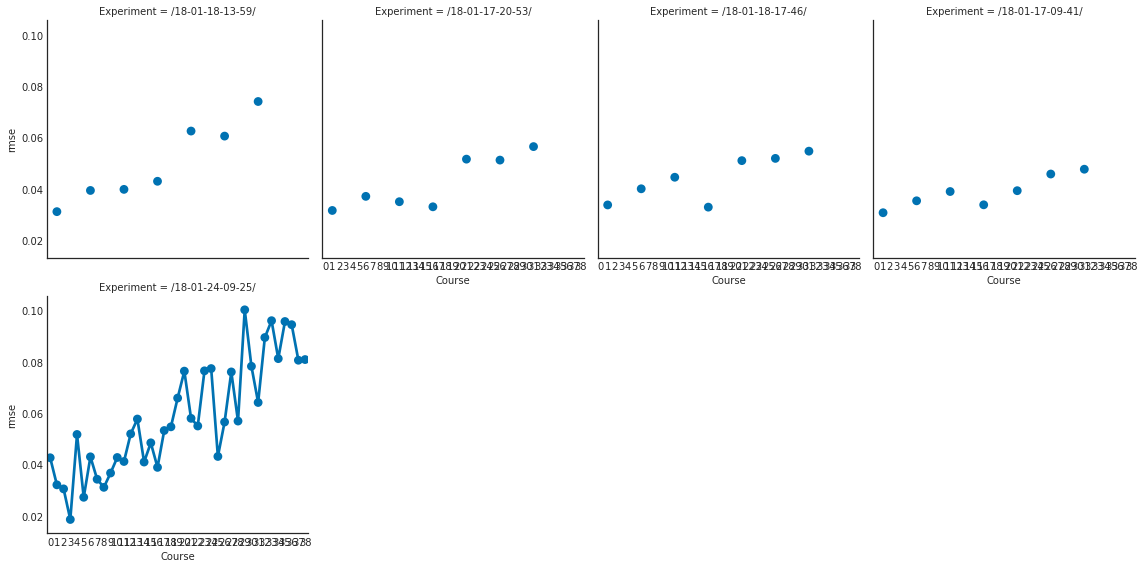

In [14]:
graphic_performances(lstm_performances)

/home/mteruel/edm/results/kdd_early_dropout/lstm/predictions/18-01-18-13-59/


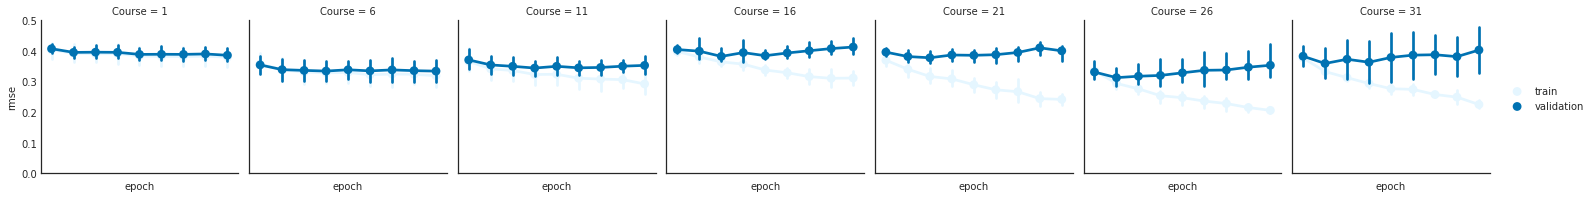

/home/mteruel/edm/results/kdd_early_dropout/lstm/predictions/18-01-17-09-41/


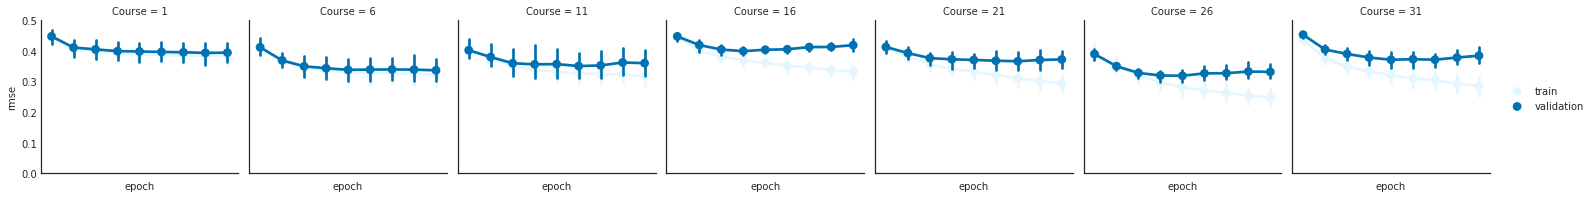

/home/mteruel/edm/results/kdd_early_dropout/lstm/predictions/18-01-17-20-53/


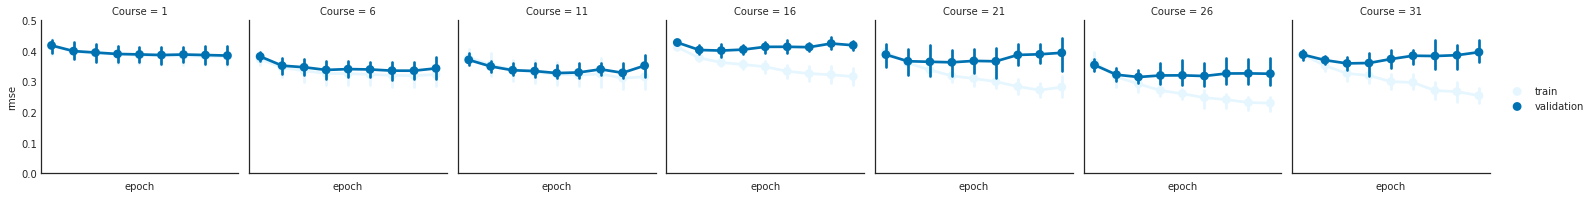

/home/mteruel/edm/results/kdd_early_dropout/lstm/predictions/18-01-18-17-46/


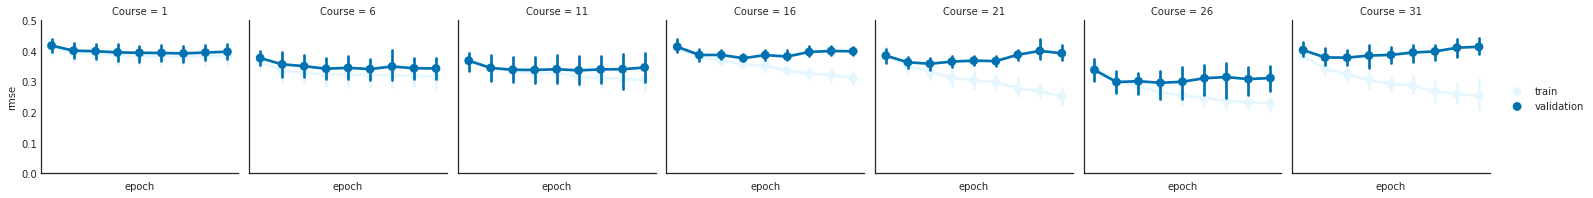

In [183]:
graphic_learning_curves(lstm_performances)

### Performance on all periods, aggregated by course

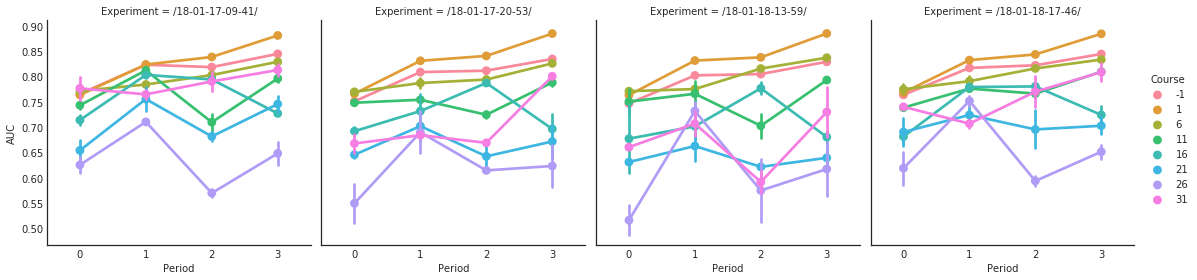

In [190]:
seaborn.factorplot(x='Period', y='AUC', hue='Course', col="Experiment", data=lstm_metrics)

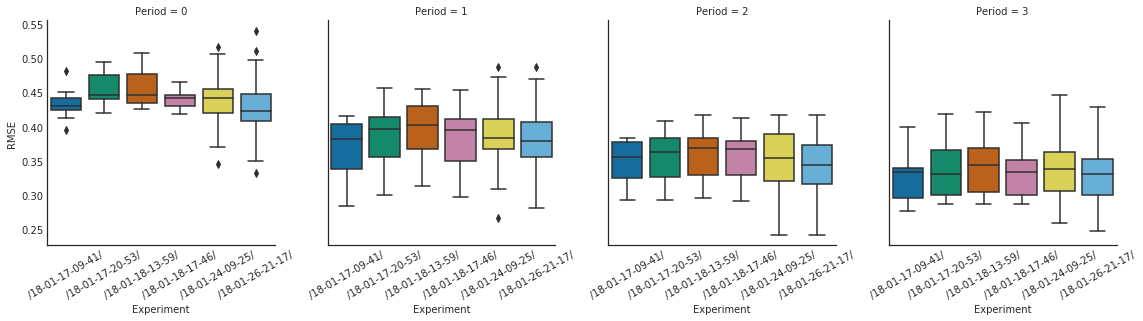

In [11]:
g = seaborn.factorplot(x='Experiment', y='RMSE', col="Period",
                       data=lstm_metrics[lstm_metrics.Course > 0], kind='box')
g.set_xticklabels(rotation=30)

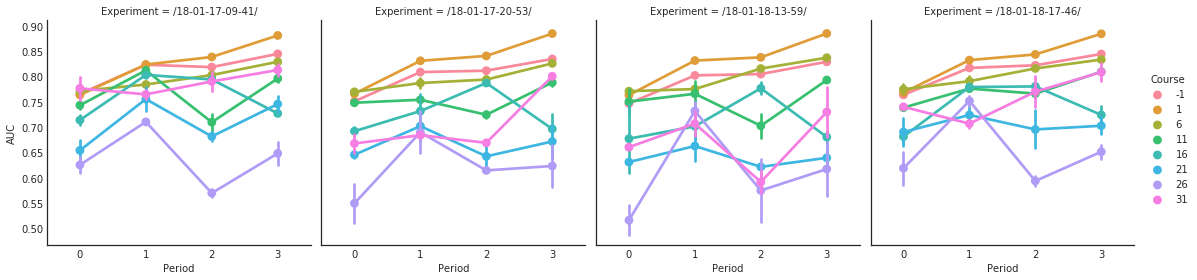

In [186]:
seaborn.factorplot(x='Period', y='AUC', hue='Course', col="Experiment", data=lstm_metrics)

### Performance on all courses, aggregated by period

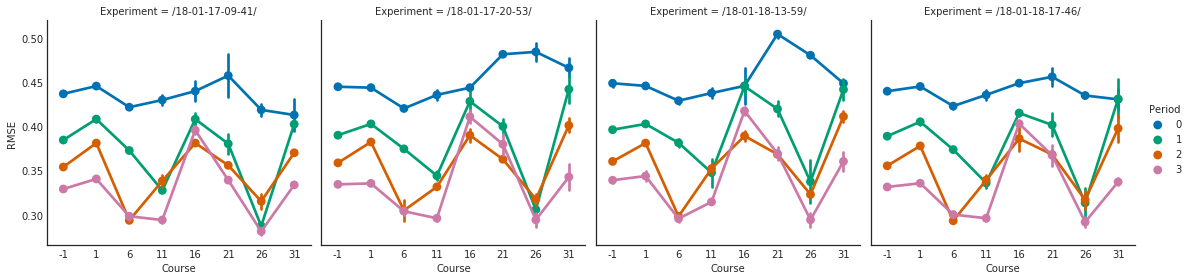

In [187]:
seaborn.factorplot(x='Course', y='RMSE', hue='Period', col="Experiment", data=lstm_metrics)

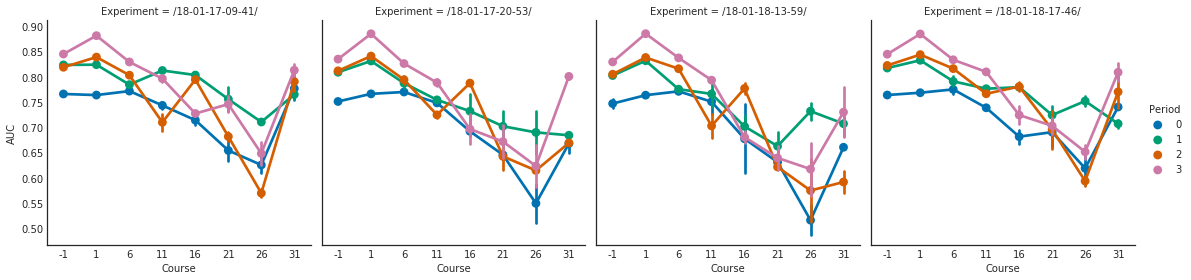

In [188]:
seaborn.factorplot(x='Course', y='AUC', hue='Period', col="Experiment", data=lstm_metrics)

# Experiments with embeddings

In [15]:
EMBEDDED_EXPERIMENTS_DIRS = [
    '/home/mteruel/edm/results/kdd_early_dropout/embedded/predictions/18-01-17-12-48/',
    '/home/mteruel/edm/results/kdd_early_dropout/embedded/predictions/18-01-17-19-14/',
    '/home/mteruel/edm/results/kdd_early_dropout/embedded/predictions/18-01-18-11-28/',
#     '/home/mteruel/edm/results/kdd_early_dropout/embedded/predictions/18-01-19-08-40/', # Bi
    '/home/mteruel/edm/results/kdd_early_dropout/embedded/predictions/18-01-23-09-28/',  # Full eval
    '/home/mteruel/edm/results/kdd_early_dropout/embedded/predictions/18-01-25-00-34/',  # Full eval
]

In [16]:
embedded_metrics = read_metrics(EMBEDDED_EXPERIMENTS_DIRS)

In [13]:
embedded_metrics[embedded_metrics.Course == -1].groupby(
    ['Experiment', 'Period']).mean()[['AUC', 'RMSE']]

AUC      RMSE
Experiment       Period                    
/18-01-17-12-48/ 0       0.768567  0.436731
                 1       0.825954  0.384683
                 2       0.833957  0.351823
                 3       0.859423  0.326341
/18-01-17-19-14/ 0       0.770457  0.434132
                 1       0.833787  0.381913
                 2       0.843070  0.348278
                 3       0.863570  0.323437
/18-01-18-11-28/ 0       0.767641  0.437750
                 1       0.828501  0.383220
                 2       0.835835  0.351295
                 3       0.860088  0.322880
/18-01-23-09-28/ 0       0.771099  0.423518
                 1       0.813404  0.378948
                 2       0.823201  0.348261
                 3       0.840040  0.325521
/18-01-25-00-34/ 0       0.765721  0.425752
                 1       0.804230  0.384934
                 2       0.822240  0.346316
                 3       0.835662  0.328265

In [104]:
embedded_metrics.groupby(['Experiment', 'Course']).mean()[METRICS_COLS][-40:]

AUC      RMSE  Accuracy        R2
Experiment       Course                                        
/18-01-23-09-28/ -1      0.811936  0.369062  0.813968  0.279852
                  0      0.802399  0.396256  0.769034  0.261827
                  1      0.836908  0.390997  0.783015  0.346080
                  2      0.836793  0.385671  0.795046  0.345099
                  3      0.765587  0.363336  0.822869  0.207060
                  4      0.832754  0.360200  0.814283  0.271797
                  5      0.831357  0.370299  0.808230  0.322878
                  6      0.814866  0.345230  0.837136  0.282430
                  7      0.795732  0.360058  0.826197  0.234324
                  8      0.780313  0.377512  0.798986  0.200173
                  9      0.797519  0.350721  0.829509  0.208501
                  10     0.776910  0.335133  0.852601  0.163642
                  11     0.790527  0.340689  0.836219  0.228951
                  12     0.847081  0.347836  0.839800  0.371892
                  13     0.878700  0.336214  0.845519  0.485209
                  14     0.832699  0.364184  0.813784  0.318584
                  15     0.725282  0.396704  0.785099  0.112315
                  16     0.785653  0.403259  0.773982  0.182795
                  17     0.784580  0.301296  0.879769  0.219405
                  18     0.812072  0.365877  0.820568  0.228257
                  19     0.849079  0.327144  0.852414  0.347637
                  20     0.741751  0.372005  0.816338  0.142931
                  21     0.735638  0.384395  0.799153  0.023973
                  22     0.766974  0.338623  0.852791  0.196983
                  23     0.764786  0.386285  0.798961  0.133365
                  24     0.835451  0.347467  0.849610  0.302100
                  25     0.697056  0.299777  0.895885  0.010847
                  26     0.705278  0.328216  0.861116  0.048001
                  27     0.761375  0.362516  0.839374  0.170881
                  28     0.650872  0.371410  0.827046 -0.050016
                  29     0.699301  0.418124  0.784017 -0.037605
                  30     0.722764  0.396833  0.805034  0.043609
                  31     0.804881  0.378506  0.808796  0.148091
                  32     0.824325  0.327293  0.864165  0.275509
                  33     0.702173  0.428244  0.761435 -0.039766
                  34     0.732249  0.311447  0.876448  0.043566
                  35     0.666671  0.388643  0.816555 -0.114090
                  36     0.650911  0.380038  0.834766 -0.076582
                  37     0.725256  0.385786  0.803903 -0.021724
                  38     0.718657  0.344619  0.863175 -0.684794

### Overfitting analysis

In [105]:
embedded_performances = read_performances(EMBEDDED_EXPERIMENTS_DIRS)

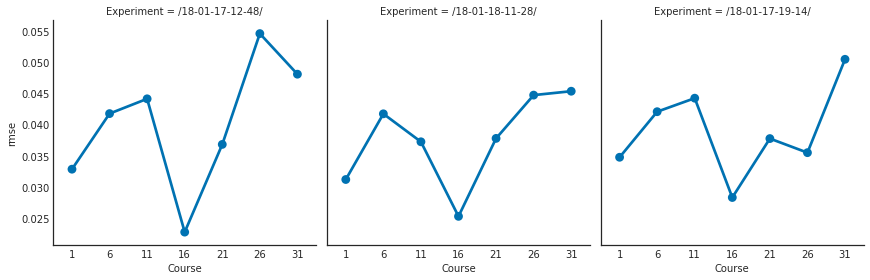

In [136]:
graphic_performances(embedded_performances)

/home/mteruel/edm/results/kdd_early_dropout/embedded/predictions/18-01-17-19-14/


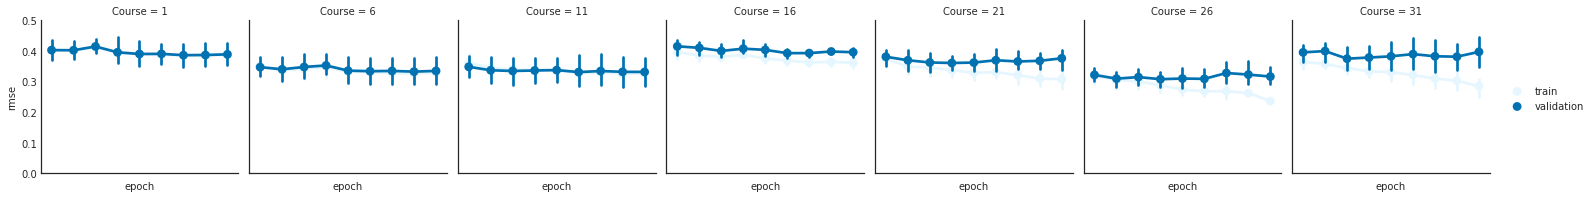

/home/mteruel/edm/results/kdd_early_dropout/embedded/predictions/18-01-17-12-48/


KeyboardInterrupt: 

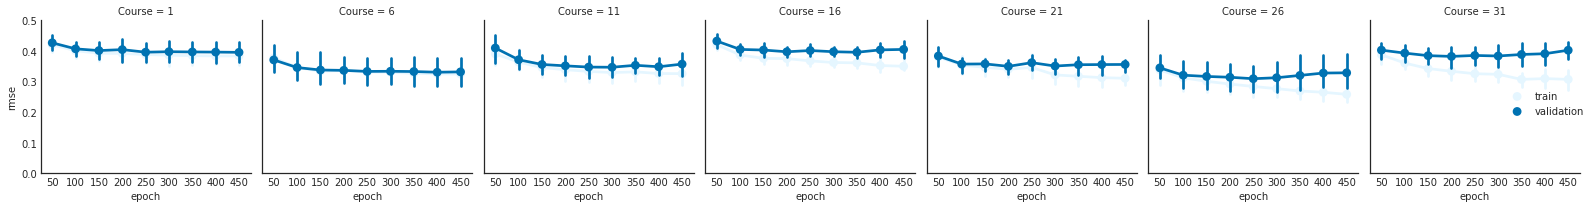

In [106]:
graphic_learning_curves(embedded_performances)

### Performance on all periods, aggregated by course

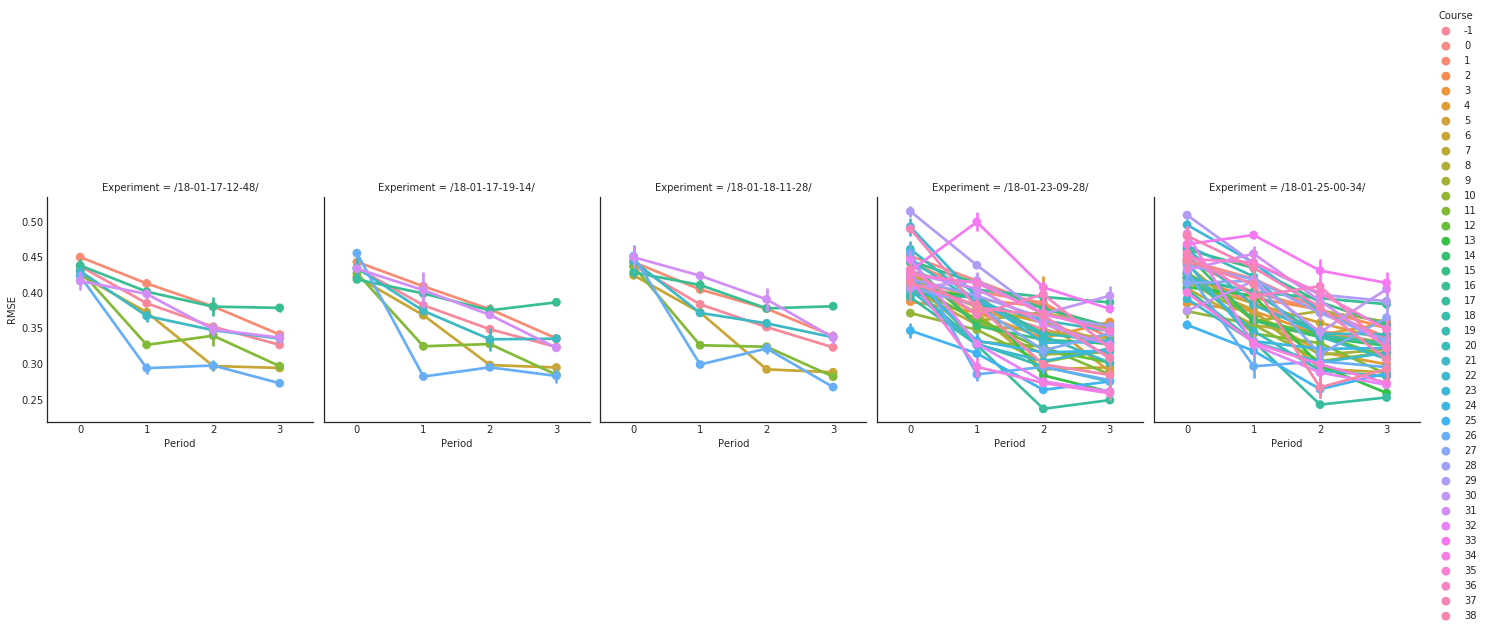

In [14]:
seaborn.factorplot(x='Period', y='RMSE', hue='Course', col="Experiment", data=embedded_metrics)

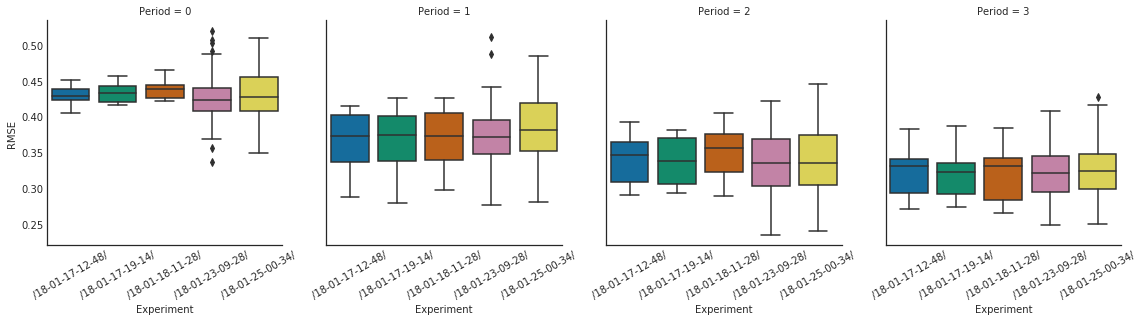

In [15]:
g = seaborn.factorplot(x='Experiment', y='RMSE', col="Period",
                   data=embedded_metrics[embedded_metrics.Course > 0], kind='box')
g.set_xticklabels(rotation=30)

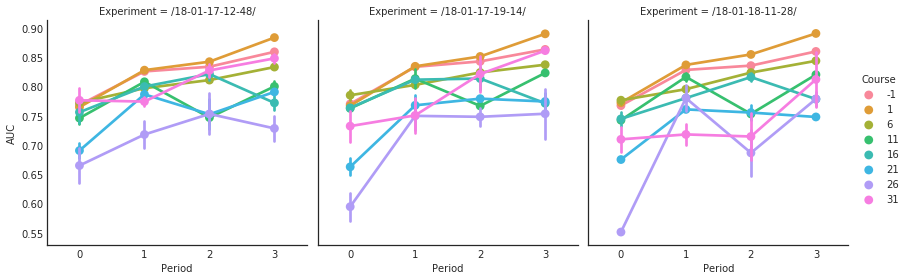

In [141]:
seaborn.factorplot(x='Period', y='AUC', hue='Course', col="Experiment", data=embedded_metrics)

### Performance on all courses, aggregated by period

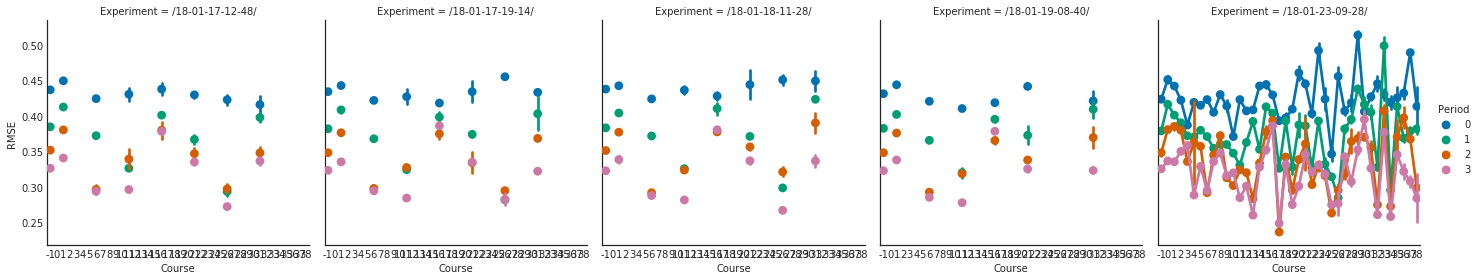

In [109]:
seaborn.factorplot(x='Course', y='RMSE', hue='Period', col="Experiment", data=embedded_metrics)

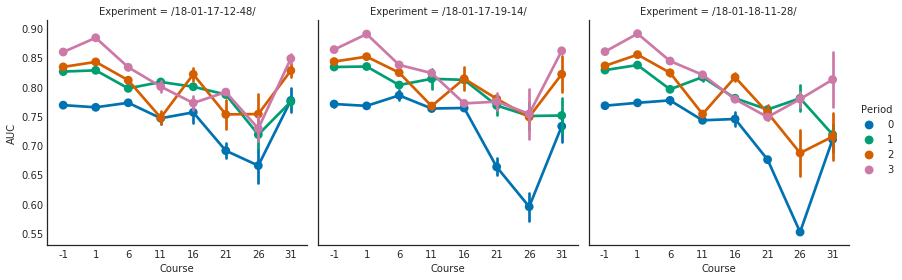

In [143]:
seaborn.factorplot(x='Course', y='AUC', hue='Period', col="Experiment", data=embedded_metrics)

# Experiments with co-embeddings

In [17]:
COEMBEDDED_EXPERIMENTS_DIRS = [
    '/home/mteruel/edm/results/kdd_early_dropout/coembedded/predictions/18-01-17-15-52/',
    '/home/mteruel/edm/results/kdd_early_dropout/coembedded/predictions/18-01-17-17-26/',
    '/home/mteruel/edm/results/kdd_early_dropout/coembedded/predictions/18-01-18-08-46/',
    '/home/mteruel/edm/results/kdd_early_dropout/coembedded/predictions/18-01-22-12-39/', # Full eval
    '/home/mteruel/edm/results/kdd_early_dropout/coembedded/predictions/18-01-23-14-20/',
    '/home/mteruel/edm/results/kdd_early_dropout/coembedded/predictions/18-01-23-16-09/', # Full eval
    '/home/mteruel/edm/results/kdd_early_dropout/coembedded/predictions/18-01-28-16-02/', # Full eval
    '/home/mteruel/edm/results/kdd_early_dropout/coembedded/predictions/18-03-06-11-03/',
    '/home/mteruel/edm/results/kdd_early_dropout/coembedded/predictions/18-03-06-11-14/',
    '/home/mteruel/edm/results/kdd_early_dropout/coembedded/predictions/18-03-06-12-25/',
    '/home/mteruel/edm/results/kdd_early_dropout/coembedded/predictions/18-03-06-12-57/',
    '/home/mteruel/edm/results/kdd_early_dropout/coembedded/predictions/18-03-06-14-32/',  # Full eval
    '/home/mteruel/edm/results/kdd_early_dropout/coembedded/predictions/18-03-06-14-36/',  # Full eval
]

In [18]:
coembedded_metrics = read_metrics(COEMBEDDED_EXPERIMENTS_DIRS)

In [19]:
coembedded_metrics[coembedded_metrics.Course == -1].groupby(
    ['Experiment', 'Period']).mean()[['AUC', 'RMSE']]

AUC      RMSE
Experiment       Period                    
/18-01-17-15-52/ 0       0.775747  0.431070
                 1       0.826853  0.386401
                 2       0.835191  0.349720
                 3       0.856909  0.326818
/18-01-17-17-26/ 0       0.779280  0.428474
                 1       0.828635  0.383662
                 2       0.849029  0.345477
                 3       0.862858  0.328534
/18-01-18-08-46/ 0       0.768941  0.438471
                 1       0.828033  0.383476
                 2       0.841412  0.348647
                 3       0.858988  0.325885
/18-01-22-12-39/ 0       0.765898  0.427431
                 1       0.800983  0.385220
                 2       0.822072  0.347380
                 3       0.832198  0.329645
/18-01-23-14-20/ 0       0.759120  0.441847
                 1       0.825731  0.386188
                 2       0.837759  0.353216
                 3       0.865319  0.324140
/18-01-23-16-09/ 0       0.765699  0.425371
                 1       0.807312  0.383108
                 2       0.828377  0.342924
                 3       0.840217  0.325987
/18-01-28-16-02/ 0       0.774703  0.419560
                 1       0.810845  0.380958
                 2       0.824232  0.345241
                 3       0.835935  0.327683
/18-03-06-11-03/ 0       0.767285  0.438664
                 1       0.826651  0.384663
                 2       0.840973  0.348649
                 3       0.861653  0.327926
/18-03-06-11-14/ 0       0.781931  0.427520
                 1       0.836793  0.377998
                 2       0.842228  0.348006
                 3       0.866940  0.321222
/18-03-06-12-25/ 0       0.787676  0.424571
                 1       0.835617  0.381727
                 2       0.839056  0.354213
                 3       0.862102  0.325858
/18-03-06-12-57/ 0       0.787560  0.422932
                 1       0.837990  0.380014
                 2       0.835293  0.354998
                 3       0.858776  0.331505
/18-03-06-14-32/ 0       0.779911  0.417072
                 1       0.814280  0.378137
                 2       0.830147  0.344528
                 3       0.841763  0.327917
/18-03-06-14-36/ 0       0.782683  0.415669
                 1       0.815151  0.377672
                 2       0.830707  0.343438
                 3       0.837825  0.331349

In [17]:
coembedded_metrics.groupby(['Experiment', 'Course']).mean()[METRICS_COLS]

AUC      RMSE  Accuracy        R2
Experiment       Course                                        
/18-01-17-15-52/ -1      0.823675  0.373502  0.805729  0.310076
                  1      0.830083  0.395951  0.776020  0.330001
                  6      0.800301  0.348394  0.833739  0.268425
                  11     0.777075  0.344910  0.838648  0.206594
                  16     0.784950  0.395217  0.781743  0.215381
                  21     0.751206  0.366734  0.818842  0.112316
                  26     0.750977  0.313897  0.866094  0.120025
                  31     0.809076  0.364260  0.822390  0.212008
/18-01-17-17-26/ -1      0.829950  0.371537  0.806169  0.317348
                  1      0.838143  0.393394  0.778173  0.338740
                  6      0.815350  0.345395  0.835085  0.280348
                  11     0.797654  0.339159  0.840686  0.230451
                  16     0.791685  0.391296  0.786933  0.230523
                  21     0.777832  0.364152  0.813702  0.130234
                  26     0.730609  0.325770  0.856804  0.059376
                  31     0.806364  0.371193  0.811781  0.177024
/18-01-18-08-46/ -1      0.824343  0.374120  0.805941  0.307807
                  1      0.840398  0.390714  0.781717  0.346906
                  6      0.815874  0.346442  0.834100  0.277417
                  11     0.791675  0.341422  0.842645  0.223980
                  16     0.779032  0.400328  0.781096  0.193447
                  21     0.726574  0.380414  0.806991  0.049913
                  26     0.722623  0.329533  0.858107  0.036265
                  31     0.778699  0.388474  0.793674  0.098614
/18-01-22-12-39/ -1      0.805288  0.372419  0.811774  0.266947
                  0      0.806328  0.401040  0.764633  0.242687
                  1      0.840169  0.391786  0.783431  0.343757
                  2      0.840182  0.383469  0.799418  0.352610
                  3      0.772900  0.362653  0.823065  0.209792
                  4      0.836579  0.348308  0.832110  0.330200
...                           ...       ...       ...       ...
/18-03-06-14-36/  9      0.794159  0.357623  0.816069  0.173310
                  10     0.787797  0.333821  0.849645  0.169163
                  11     0.798304  0.335036  0.846710  0.251729
                  12     0.848698  0.347791  0.839879  0.372589
                  13     0.878467  0.337887  0.841037  0.480740
                  14     0.838001  0.364038  0.811873  0.318892
                  15     0.752519  0.385045  0.787216  0.162311
                  16     0.797140  0.393831  0.773141  0.220414
                  17     0.783394  0.300915  0.875169  0.219152
                  18     0.834160  0.351979  0.831556  0.285353
                  19     0.850581  0.325945  0.848766  0.352717
                  20     0.761663  0.361832  0.819548  0.183190
                  21     0.759610  0.358876  0.824725  0.150688
                  22     0.773802  0.337254  0.843212  0.199923
                  23     0.799409  0.365649  0.812787  0.221436
                  24     0.851344  0.335954  0.852138  0.347497
                  25     0.713887  0.287812  0.905555  0.087321
                  26     0.771702  0.305061  0.874738  0.166698
                  27     0.799882  0.343120  0.846780  0.254152
                  28     0.687679  0.353422  0.838241  0.044253
                  29     0.765360  0.386739  0.795230  0.104368
                  30     0.803062  0.358197  0.822263  0.221529
                  31     0.821025  0.363889  0.813244  0.213561
                  32     0.856528  0.314280  0.861517  0.331378
                  33     0.790708  0.382011  0.796624  0.174696
                  34     0.776366  0.296082  0.885964  0.129375
                  35     0.695582  0.375327  0.813074 -0.035286
                  36     0.794386  0.343919  0.845848  0.120178
                  37     0.763459  0.360707  0.831246  0.101273
                  38     0.725576  0.312522  0.872216 -0.36036

### Overfitting analysis

In [12]:
coembedded_performances = read_performances(COEMBEDDED_EXPERIMENTS_DIRS)

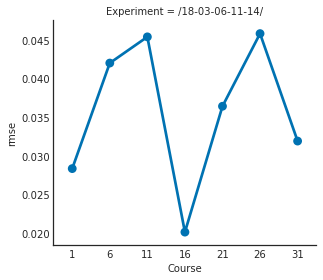

In [13]:
graphic_performances(coembedded_performances)

/home/mteruel/edm/results/kdd_early_dropout/coembedded/predictions/18-03-06-11-14/


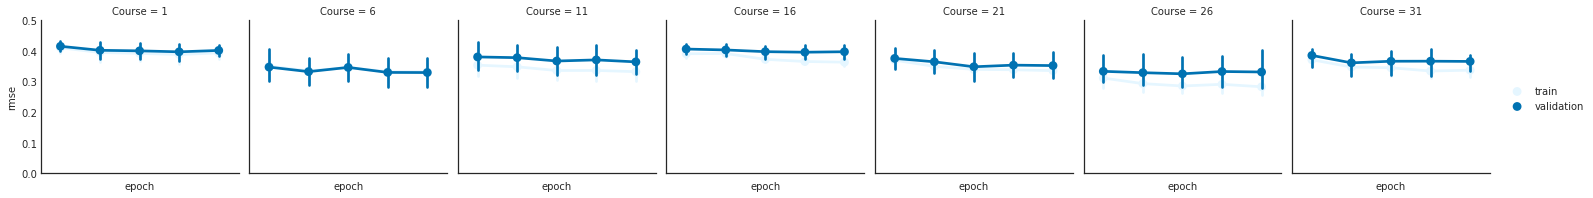

In [14]:
graphic_learning_curves(coembedded_performances)

### Performance on all periods, aggregated by course

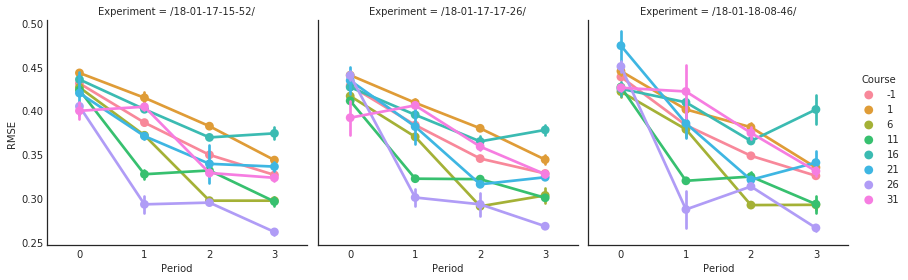

In [119]:
seaborn.factorplot(x='Period', y='RMSE', hue='Course', col="Experiment", data=coembedded_metrics)

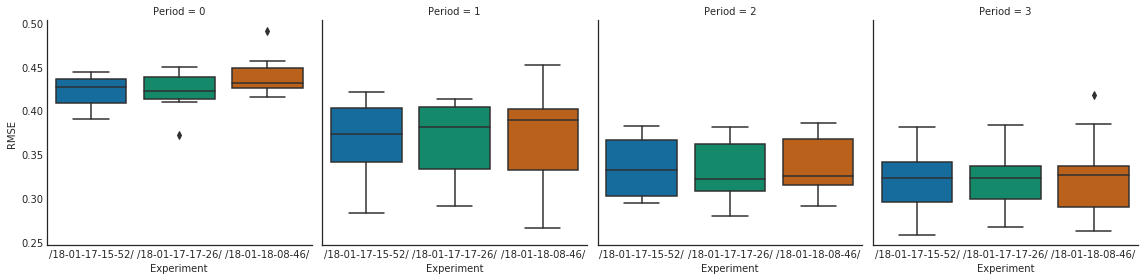

In [129]:
seaborn.factorplot(x='Experiment', y='RMSE', col="Period",
                   data=coembedded_metrics[coembedded_metrics.Course > 0], kind='box')

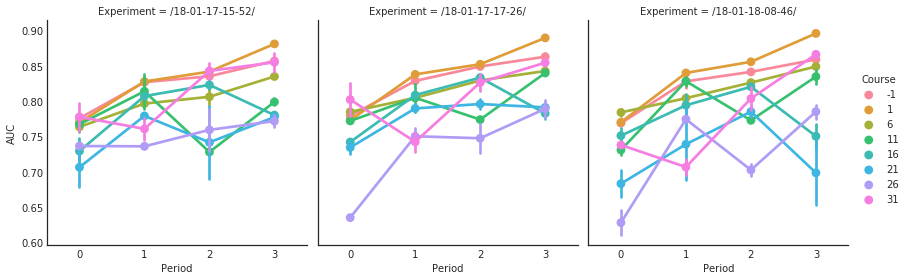

In [121]:
seaborn.factorplot(x='Period', y='AUC', hue='Course', col="Experiment", data=coembedded_metrics)

### Performance on all courses, aggregated by period

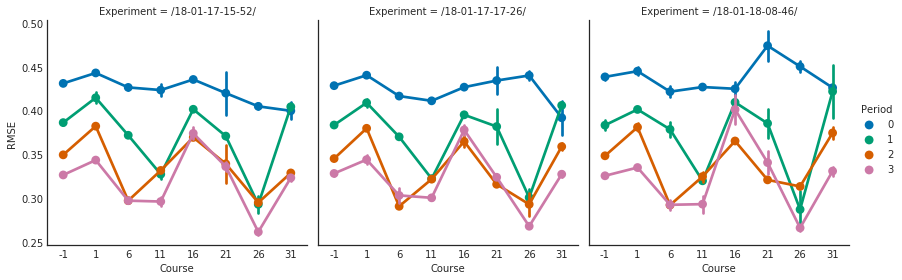

In [122]:
seaborn.factorplot(x='Course', y='RMSE', hue='Period', col="Experiment", data=coembedded_metrics)

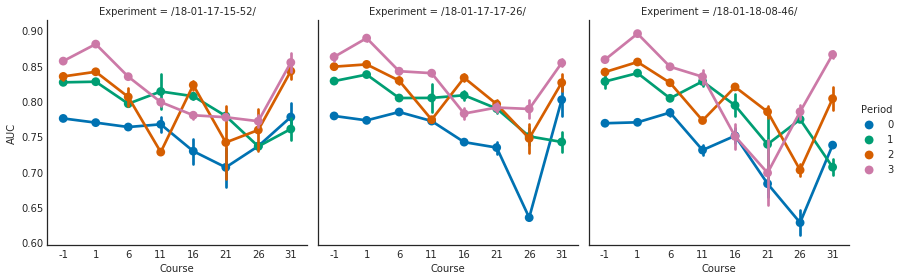

In [123]:
seaborn.factorplot(x='Course', y='AUC', hue='Period', col="Experiment", data=coembedded_metrics)

# Full evaluation metrics

In [20]:
def get_best_metrics(all_metrics_df, DIRNAMES):
    best_performances = all_metrics_df.set_index(
        ['Experiment', 'Run']).groupby(['Course', 'Period'])['AUC'].apply(numpy.argmax)
    predictions_dfs = []
    best_metrics = []
    best_metrics_index = []
    for ((course, period), (experiment, run)) in best_performances.items():
        if course < 0 or period >= 3:
            continue
        best_metrics.append((experiment, run, course, period))
        for dirname in DIRNAMES:
            if not experiment in dirname:
                continue
            for filename in get_runs(dirname):
                if '_c{}.p'.format(course) in filename:
                    filepath = os.path.join(dirname, filename)
                    predictions = read_predictions(filepath)
                    predictions['Course'] = course
                    #predictions['Experiment'] = experiment
                    predictions_dfs.append(
                        predictions[(predictions.run == run) & (predictions.period == period)])
    predictions = pandas.concat(predictions_dfs)
    predictions.loc[:,'run'] = 0
    best_metrics_by_course = all_metrics_df.set_index(['Experiment', 'Run', 'Course', 'Period']).loc[best_metrics]
    return read_file_metrics(predictions), best_metrics_by_course.reset_index().set_index(['Course', 'Period'])

In [51]:
def course_category(course):
    if course < 0:
        return None
    if course <= 4:
        return 'Small'
    if course <= 13:
        return 'Medium'
    return 'Large'

def add_course_category(metrics_df):
    metrics_df.loc[:, 'CourseSize'] = metrics_df.reset_index()['Course'].apply(course_category)
    return metrics_df

In [63]:
co_best_metrics, co_best_metrics_by_course = get_best_metrics(coembedded_metrics, COEMBEDDED_EXPERIMENTS_DIRS)
co_best_metrics

,AUC,RMSE,Accuracy,R2,Support,Run,Period
0,0.790564,0.412936,0.759820,0.239689,15963,0,0
1,0.826384,0.373320,0.806959,0.302593,21726,0,1
2,0.842191,0.338595,0.845080,0.323658,26136,0,2


In [64]:
co_best_metrics_by_course

Experiment  Run       AUC      RMSE  Accuracy        R2  \
Course Period                                                                  
0      0       /18-01-22-12-39/    1  0.762593  0.443515  0.711405  0.204048   
       1       /18-01-22-12-39/    0  0.807260  0.424127  0.730465  0.245040   
       2       /18-01-22-12-39/    0  0.810898  0.400451  0.757073  0.169439   
1      0       /18-01-22-12-39/    0  0.778012  0.440582  0.713969  0.223142   
       1       /18-01-18-08-46/    1  0.840101  0.401072  0.768072  0.343214   
       2       /18-01-23-16-09/    0  0.856488  0.374444  0.807115  0.377368   
2      0       /18-03-06-14-32/    0  0.810156  0.419776  0.755932  0.294808   
       1       /18-01-22-12-39/    0  0.844857  0.387344  0.792303  0.359994   
       2       /18-01-22-12-39/    1  0.841572  0.374052  0.807264  0.345237   
3      0       /18-01-22-12-39/    1  0.717016  0.390925  0.792186  0.071706   
       1       /18-01-23-16-09/    1  0.781257  0.373239  0.808672  0.202962   
       2       /18-01-22-12-39/    0  0.799241  0.334223  0.857388  0.257331   
4      0       /18-01-23-16-09/    0  0.804271  0.415266  0.751948  0.258147   
       1       /18-01-23-16-09/    0  0.822517  0.370152  0.811172  0.298135   
       2       /18-01-23-16-09/    1  0.864800  0.304013  0.879671  0.394792   
5      0       /18-03-06-14-36/    0  0.770964  0.416627  0.746154  0.171698   
       1       /18-01-23-16-09/    0  0.833086  0.379990  0.797989  0.310972   
       2       /18-01-23-16-09/    1  0.855446  0.355805  0.825372  0.362572   
6      0       /18-03-06-14-36/    1  0.794171  0.414269  0.759878  0.251082   
       1       /18-03-06-12-57/    0  0.813571  0.369667  0.806320  0.278478   
       2       /18-01-17-17-26/    1  0.834562  0.288825  0.888007  0.296876   
7      0       /18-03-06-14-36/    1  0.774564  0.406586  0.775264  0.228123   
       1       /18-01-23-16-09/    0  0.797406  0.349923  0.841584  0.225724   
       2       /18-01-22-12-39/    0  0.831583  0.352762  0.845320  0.252088   
8      0       /18-01-28-16-02/    0  0.764693  0.427239  0.736508  0.206526   
       1       /18-01-23-16-09/    1  0.786636  0.352108  0.822408  0.180911   
       2       /18-03-06-14-36/    0  0.791553  0.368812  0.813246  0.222005   
9      0       /18-01-23-16-09/    1  0.738686  0.407711  0.763941  0.111242   
       1       /18-01-28-16-02/    1  0.817041  0.353397  0.828369  0.239432   
       2       /18-01-23-16-09/    1  0.838310  0.312626  0.867580  0.267889   
...                         ...  ...       ...       ...       ...       ...   
29     0       /18-01-22-12-39/    0  0.733274  0.479865  0.672515 -0.088129   
       1       /18-03-06-14-36/    1  0.759544  0.404626  0.787330  0.196670   
       2       /18-03-06-14-36/    0  0.840787  0.314214  0.878788  0.261999   
30     0       /18-03-06-14-36/    1  0.819431  0.336486  0.844560  0.297795   
       1       /18-03-06-14-36/    0  0.765611  0.378188  0.808696  0.182574   
       2       /18-03-06-14-36/    0  0.890535  0.305874  0.869732  0.366341   
31     0       /18-01-17-17-26/    0  0.825611  0.372703  0.810458  0.302512   
       1       /18-03-06-11-14/    1  0.812041  0.368646  0.835000  0.232637   
       2       /18-03-06-12-25/    1  0.857692  0.328766  0.825532  0.234728   
32     0       /18-03-06-14-36/    0  0.822626  0.430947  0.745098  0.087301   
       1       /18-01-28-16-02/    0  0.896197  0.287668  0.900621  0.480369   
       2       /18-03-06-14-36/    0  0.911903  0.251177  0.919028  0.468511   
33     0       /18-01-23-16-09/    0  0.753691  0.426216  0.776398  0.085313   
       1       /18-03-06-14-36/    0  0.779123  0.411460  0.780105  0.145515   
       2       /18-01-23-16-09/    1  0.818981  0.362066  0.807512  0.213294   
34     0       /18-03-06-14-32/    0  0.784414  0.401905  0.804348  0.050577   
       1       /18-01-22-12-39/    0  0.866843  0.290721  0.875676  0.193350   
       2       /18-03

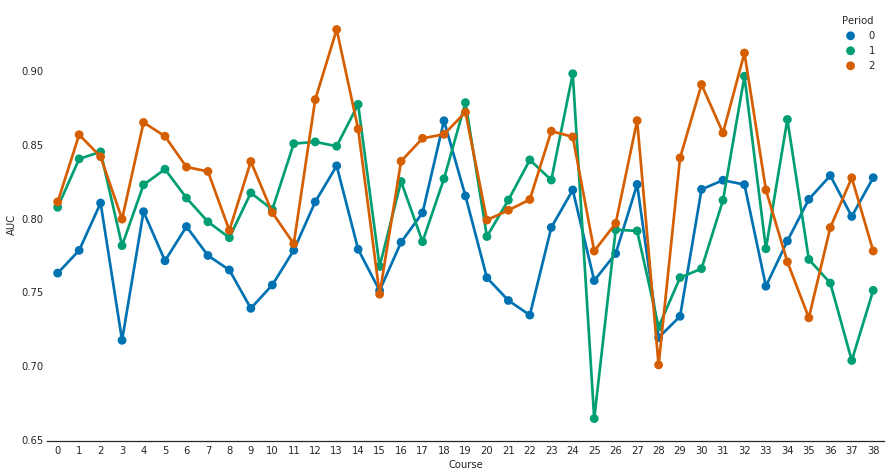

In [26]:
plt.subplots(figsize=(15,8))
seaborn.pointplot(data=co_best_metrics_by_course.reset_index(), x='Course', y='AUC', hue='Period')
seaborn.despine(left=True)

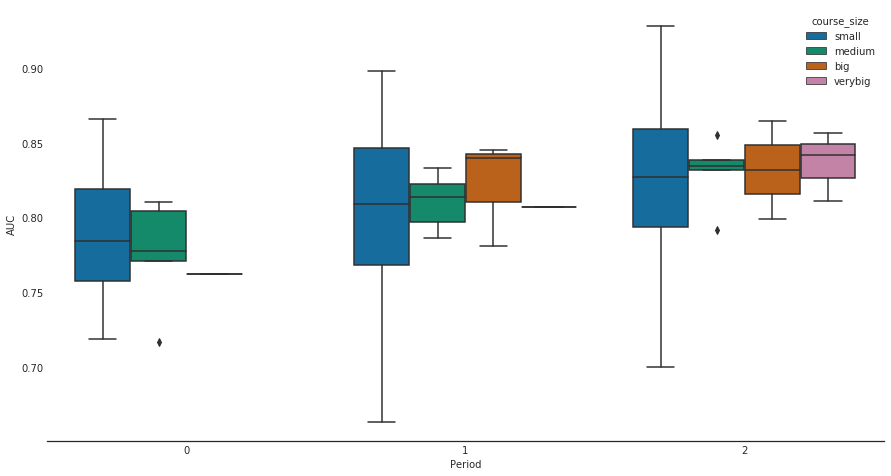

In [24]:
plt.subplots(figsize=(15,8))
seaborn.boxplot(data=co_best_metrics_by_course.reset_index(), x='Period', y='AUC', hue='course_size')
seaborn.despine(left=True)

---

In [65]:
em_best_metrics, em_best_metrics_by_course = get_best_metrics(embedded_metrics, EMBEDDED_EXPERIMENTS_DIRS)
em_best_metrics

,AUC,RMSE,Accuracy,R2,Support,Run,Period
0,0.780138,0.420402,0.751989,0.211945,15963,0,0
1,0.818225,0.377574,0.805072,0.286608,21726,0,1
2,0.831838,0.343191,0.845041,0.305170,26136,0,2


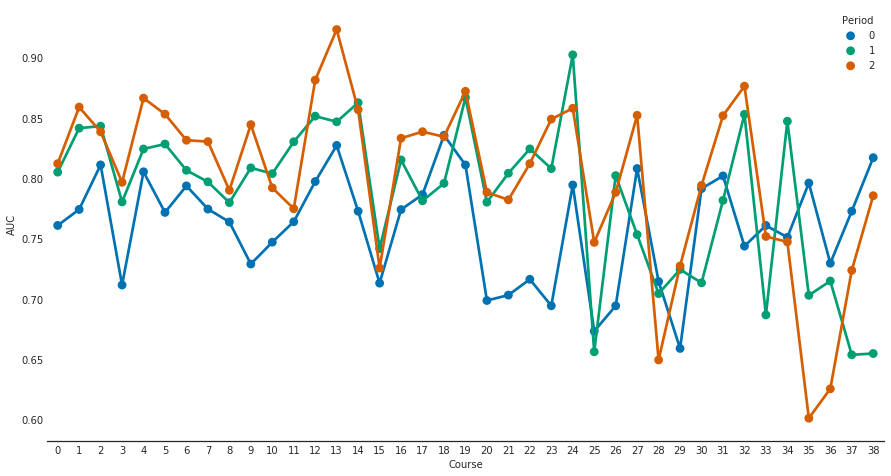

In [28]:
plt.subplots(figsize=(15,8))
seaborn.pointplot(data=em_best_metrics_by_course.reset_index(), x='Course', y='AUC', hue='Period')
seaborn.despine(left=True)

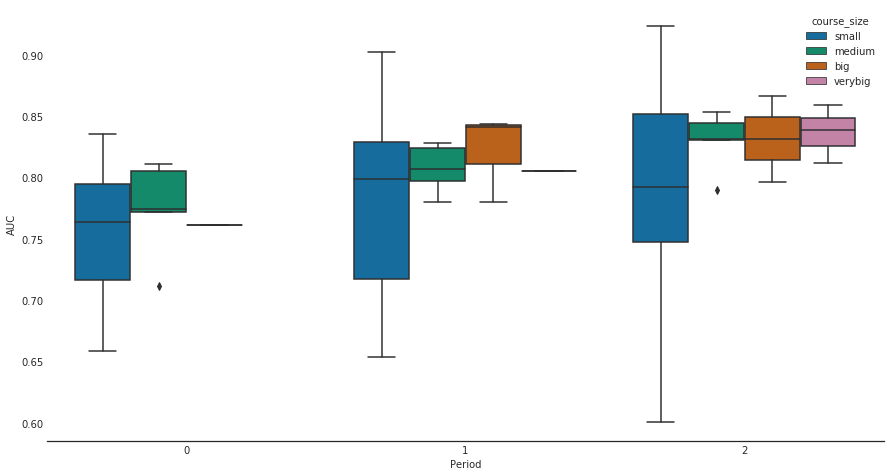

In [29]:
plt.subplots(figsize=(15,8))
seaborn.boxplot(data=em_best_metrics_by_course.reset_index(), x='Period', y='AUC', hue='course_size')
seaborn.despine(left=True)

---

In [66]:
lstm_best_metrics, lstm_best_metrics_by_course = get_best_metrics(lstm_metrics, LSTM_EXPERIMENTS_DIRS)
lstm_best_metrics

,AUC,RMSE,Accuracy,R2,Support,Run,Period
0,0.771561,0.423916,0.748919,0.198717,15963,0,0
1,0.804629,0.383431,0.804520,0.264304,21726,0,1
2,0.817545,0.349083,0.839761,0.281108,26136,0,2


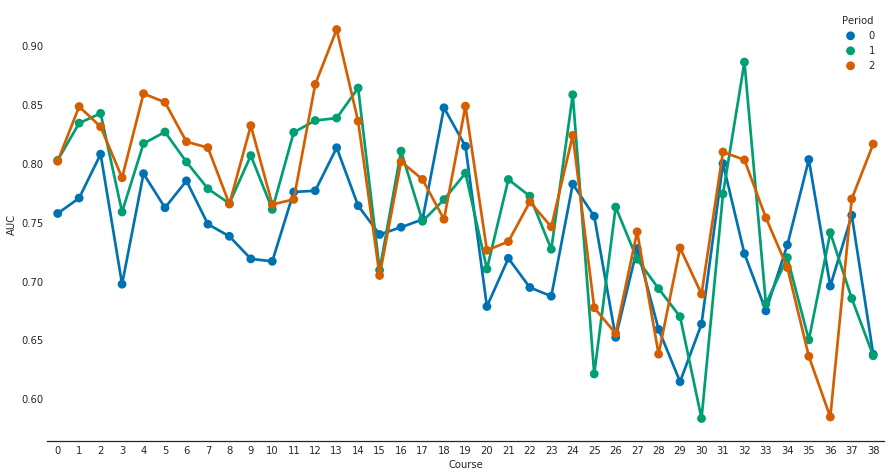

In [33]:
plt.subplots(figsize=(15,8))
seaborn.pointplot(data=lstm_best_metrics_by_course.reset_index(), x='Course', y='AUC', hue='Period')
seaborn.despine(left=True)

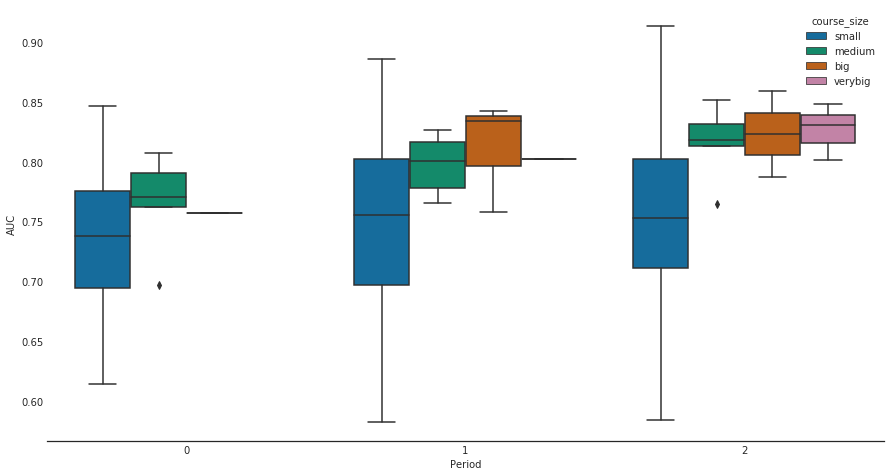

In [34]:
plt.subplots(figsize=(15,8))
seaborn.boxplot(data=lstm_best_metrics_by_course.reset_index(), x='Period', y='AUC', hue='course_size')
seaborn.despine(left=True)

In [80]:
lstm_best_metrics_by_course.loc[:,'Model'] = 'LSTM'
em_best_metrics_by_course.loc[:,'Model'] = 'E-LSTM'
co_best_metrics_by_course.loc[:,'Model'] = 'Co-ELSTM'

In [81]:
model_pal = {'Co-ELSTM': colors.dark_green}
model_pal['LSTM'] = colors.red
model_pal['E-LSTM'] = colors.dark_blue

In [82]:
all_results = pandas.concat(
        [lstm_best_metrics_by_course.reset_index(), em_best_metrics_by_course.reset_index(),
         co_best_metrics_by_course.reset_index()])

In [83]:
all_results[:3]

,Course,Period,Experiment,Run,AUC,RMSE,Accuracy,R2,Support,Model
0,0,0,/18-01-24-09-25/,0,0.757065,0.452730,0.680111,0.170630,1438,LSTM
1,0,1,/18-01-24-09-25/,1,0.802153,0.420328,0.740851,0.258505,2022,LSTM
2,0,2,/18-01-24-09-25/,1,0.801409,0.381660,0.795549,0.245557,2651,LSTM


In [84]:
sizes = {0: 'big', 1: 'big', 2: 'big', 3: 'big', 4: 'big', 5: 'big', 6: 'medium', 7: 'medium',
         8: 'medium', 9: 'medium', 10: 'medium', 11: 'medium', 12: 'medium', 13: 'medium', 14: 'medium',
         15: 'medium', 16: 'medium', 17: 'medium', 18: 'medium', 19: 'medium', 20: 'medium', 21: 'medium',
         22: 'medium', 23: 'small', 24: 'small', 25: 'small', 26: 'small', 27: 'small', 28: 'small',
         29: 'small', 30: 'small', 31: 'small', 32: 'small', 33: 'small', 34: 'small', 35: 'small',
         36: 'small', 37: 'small', 38: 'small'}

In [85]:
all_results['CourseSize'] = all_results["Course"].map(lambda x:sizes[x])

In [86]:
all_results[['CourseSize', 'Support']].groupby(['CourseSize']).agg(['min', 'max', 'count'])

Support            
               min   max count
CourseSize                    
big            770  2651    54
medium         256  1134   153
small           74   323   144

/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


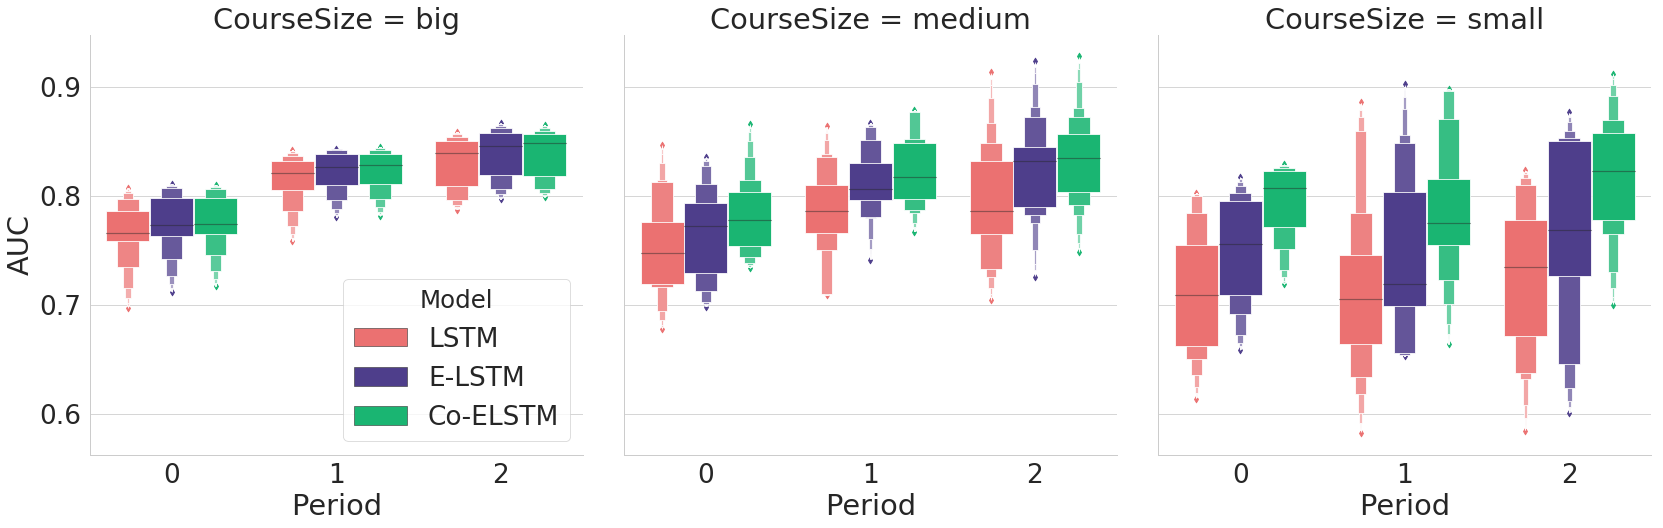

In [92]:
seaborn.set_context("paper", font_scale=3)
seaborn.factorplot(data=all_results,
                   x='Period', col='CourseSize', y='AUC',
                   hue='Model', kind='boxen', palette=model_pal,
                   size=8, legend_out=False)
seaborn.despine()

/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


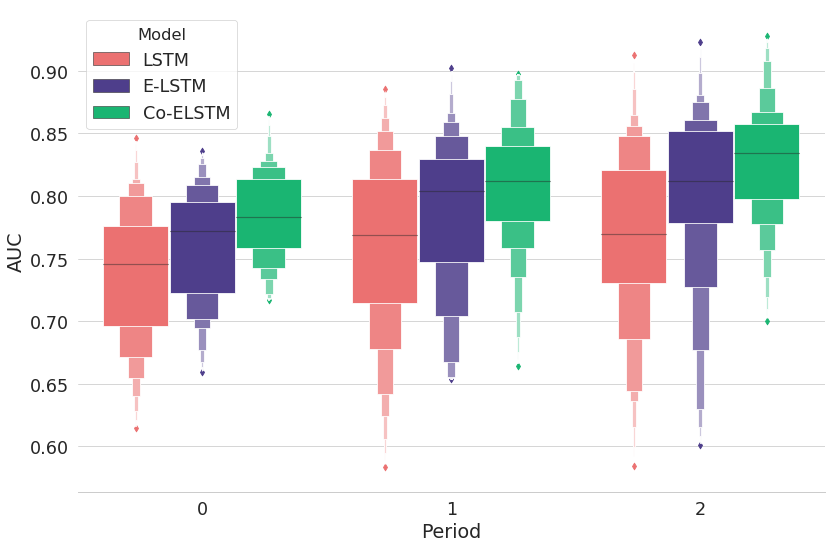

In [93]:
seaborn.set_context("paper", font_scale=2)
seaborn.factorplot(data=all_results,
                   x='Period', y='AUC', hue='Model', palette=model_pal, kind='boxen',
                   size=8, aspect=1.5, legend_out=False)
seaborn.despine(left=True)

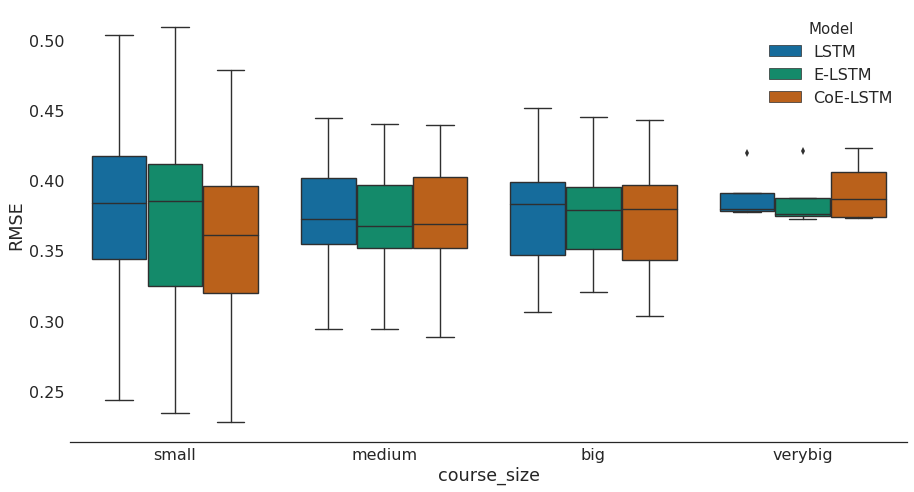

In [44]:
seaborn.set_context("paper", font_scale=2)
plt.subplots(figsize=(15,8))
seaborn.boxplot(data=pandas.concat(
        [lstm_best_metrics_by_course.reset_index(), em_best_metrics_by_course.reset_index(),
         co_best_metrics_by_course.reset_index()]),
    x='course_size', y='RMSE', hue='Model', palette='colorblind')
seaborn.despine(left=True)

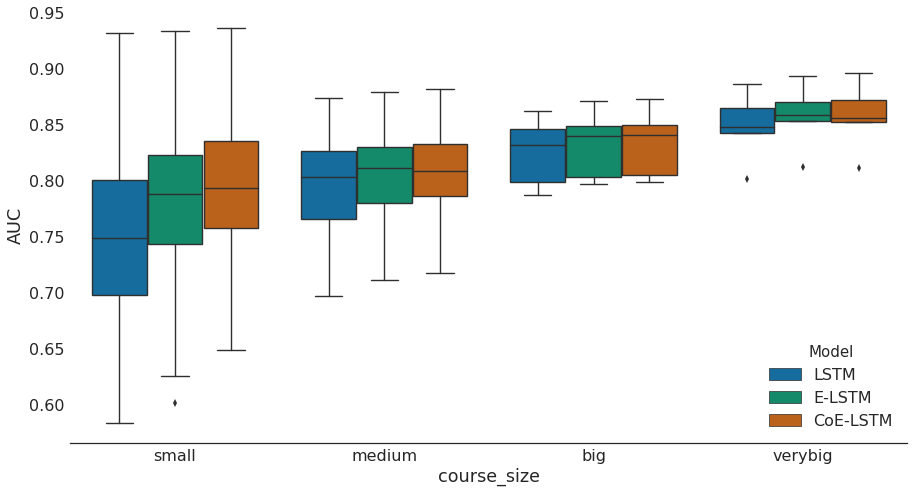

In [112]:
plt.subplots(figsize=(15,8))
seaborn.boxplot(data=pandas.concat(
        [lstm_best_metrics_by_course.reset_index(), em_best_metrics_by_course.reset_index(),
         co_best_metrics_by_course.reset_index()]),
    x='course_size', y='AUC', hue='Model', palette='colorblind')
seaborn.despine(left=True)

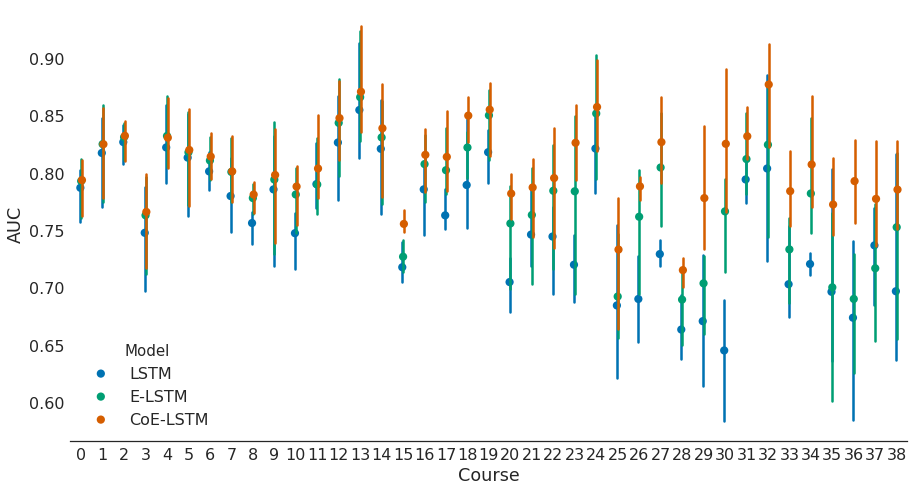

In [45]:
plt.subplots(figsize=(15,8))
seaborn.pointplot(data=pandas.concat(
        [lstm_best_metrics_by_course.reset_index(), em_best_metrics_by_course.reset_index(),
         co_best_metrics_by_course.reset_index()]), x='Course', y='AUC', hue='Model', dodge=True, join=False)
seaborn.despine(left=True)

/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


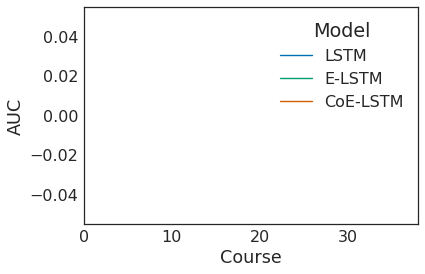

In [46]:
seaborn.tsplot(data=pandas.concat(
        [lstm_best_metrics_by_course.reset_index(), em_best_metrics_by_course.reset_index(),
         co_best_metrics_by_course.reset_index()]), time='Course', value='AUC', condition='Model')